_Julia Callebat_

***

# Introduction

This work is mainly based on the work of Victor V. Albert, Kyungjoo Noh and Kasper Duivenvoorden in _Performance and structure of bosonic codes_ ([arXiv:1708.05010 quant-ph](https://arxiv.org/pdf/1708.05010.pdf)). In this paper, they focus on five different code classes: the `cat`-codes, the `binomial` codes, the `num`erically optimized codes, and the `gkps` and `gkp` codes. They are all continuous-variable (CV) encoding schemes developped more or less recently, the `cat` and `gkp(s)` codes dating back to 1999 and the `bin` and `num` codes recently designed. 

Their purpose is to compare those codes using one same error model. Here, they focus on the bosonic pure-loss channel, the best model for the optical cavities. Photon loss is indeed the most common incoherent error process, and the most important in terms of effects on the transmission. 

It should be noted however that this work is highly theoritical; it consists of numerical analysis of the theoritical performances of those codes, assuming that the encoding, recovery and decoding operations are done perfectly. Thus, their results are loose guidelines and not practical suggestions. 


I use in particular their study of the expressions of the logical states of the codes aforementioned, and of the pure-loss channel in itself. My goal is to provide a visual representation of the codes before and after the pure-loss channel, and to see whether the results of the paper on the quality of the codes in absolute and in respect to one another can be seen using the Wigner function as a visual representation.

## Remarks

This work is done using Python, and more precisely the [QuTiP library](http://qutip.org/docs/latest/index.html "Quantum Toolbox in Python"). While some numerical decisions are motivated by the article on which this work is based, whether because of physical or practical reasons, some are mostly made because of the limitations of Python. In any case, justification will be provided for all those decisions. 



In [1]:
import numpy as np
import qutip as qt
from qutip import *
import matplotlib.pyplot as plt
import math

***

# The bosonic pure-loss channel

This is one of the prevailing CV noise models, alongside the classical noise (Gaussian noise or displacement). It is a contraction of phase space to the vacuum. It is also knows more simply as the lossy channel, and we use here `gama`, the dimensionless loss rate parameter to characterize the channel: it is function of the damping parameter, which is expressed differently for microwave or optical cavities (function then of the excitation loss rate and time interval) and for optical fibers (function tthe of the fiber length and attenuation length).

The pure-loss channel can be described by its Kraus operators, given in (1.4). However, for practicality (Python does not support infinite sums of non-integer) and because to leading order in `gama` they suffice to characterise the channel, we only use the first two Kraus operators given by (1.5):

In [2]:
def E_0(N, gama):
    l = Qobj()
    l = qeye(N) - 1/2*gama*num(N)
    return l
    
def E_1(N, gama):
    l = Qobj()
    l = np.sqrt(gama)/np.sqrt(1-gama)*(1-gama/2)*destroy(N)
    return l

def E_2(N, gama):
    l = Qobj()
    l = (gama/(1-gama))*(destroy(N))**2/np.sqrt(2)*(1-gama*num(N)/2)
    return l

def E_l(N, gama, l):
    k = Qobj()
    k = (gama/(1-gama))**(l/2)*(1-gama/2)/math.sqrt(np.math.factorial(l))*destroy(N)**l
    return k

* `E0` is function of the Identity matrix and the number operator (the product of the raising and lowering operators), while `E1` is function only of the lowering operator. 
* The `N` parameter represents the number of levels in Hilbert space. Since the mean occupation number studied in the original paper does not exceed 10, we will take `N = 20` in all following calculations in order to keep those objects easily computable by Python.
* `E2` was added after the first computations of the distance between the codewords gave unexpected result, to check that there was no major imprecision due to only using the first two Kraus operators. It showed to have little to no impact on all the plots, but was still left to keep that small extra precision.

As the Kraus operators act on the density matrix representations of the states, we define the `density` function that, given a pure state, returns its density matrix -- the product of the state ket and its bra. We use the `dag()` function of QuTiP that gives the state dagger.

In [3]:
def density(state):
    l = Qobj()
    l = state*state.dag()
    return l

Then, we can fully describe the effect of the channel on the density matrix of a logical state using the following function:

In [4]:
def channel(dens, N, gama):
    l = Qobj()
    l = E_0(N,gama)*dens*E_0(N,gama).dag() + E_1(N,gama)*dens*E_1(N,gama).dag() + E_2(N,gama)*dens*E_2(N,gama).dag()
    return l

def chan(dens, N, gama):
    l = Qobj()
    l = sum((E_l(N, gama, k)*dens*E_l(N, gama, k).dag()) for k in range(0,150))
    return l

## Alternative definition

In [5]:
H = 0.5*(identity(20)+num(20))


***

# The cat code
## Definition

The `cat` codes are defined by their parameters `alpha`, and `S`. Those parameters being given, the cat code logical states are coherent states (function of `alpha`) projected onto subspaces of occupation number modulo 2(`S` + 1). Thus, the `S` parameter gives the spacing between Fock states supporting the logical states, or, when using the coherent states instead of the Fock states, the `S` parameters gives the number of coherent states used. In the large `alpha` limit, it gives exactly the number of coherent states distributed equidistantly on a circle of radius `alpha` in phase space, which is to say it gives the spacing (`1/(2(S+1))`) between the coherent states on the circle of radius `alpha` in phase space. 
  
The `S` parameter being the spacing between the Fock states supporting the two different logical states, it gives also the number of loss events that can be detected -- but that cannot always be correctable.

***
The global expression of those logical states is given in equation (5.1), but for the purposes of our work we will use the simple example of the `cat(alpha = 2, S = 1)` code and thus the expression given by equation (5.8). The `S = 1` parameter have been chosen by the authors of the original paper for simplicity reasons, and I have set `alpha` to be equal to 2 in order to be able to compare my representation to the one given in Figure 1.

Since `S = 1`, exactly one loss event is always detectable but not always correctable. Furthermore, as show in Figs. 4(a-c), there exists a "sweet spot" for `cat` codes, that is to say an `alpha*` that balances the backaction with the loss errors. I assume this is why they chose this particular `alpha` for the `S` selected, but it is not explicited in the original paper.

***

The function that gives the two logical states is thus defined as follow, with `mu` in {0,1} being the logical state considered:

In [6]:
def cat_L(N, alpha, mu):
    l = Qobj()
    l = (
        coherent(N,alpha) + coherent(N, -alpha) 
        + ((-1)**mu)*(coherent(N,1J*alpha)+coherent(N,-1J*alpha))
    )/(4*np.sqrt(2*(np.cosh(alpha**2) + ((-1)**mu)*np.cos(alpha**2))))
    return l.unit()

## Representation of the logical states

In order to have the clearest and most complete representation possible, we plot the two logical states `|0>` and `|1>`, but also the maximally mixed state `1/2 * (|0><0| + |1><1|)`.

As mentionned in the introduction, we use the Wigner function plots for the visual representation, since the Wigner function can be seen as the realisation of the density matrix in phase space.

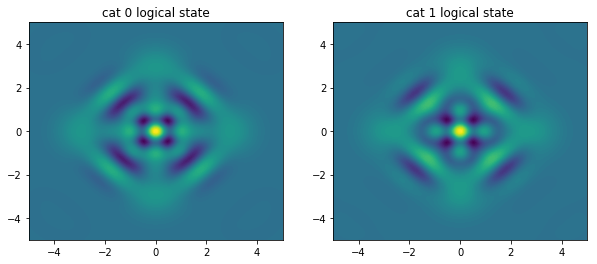

In [7]:
xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(1, 2, figsize=(10,4))
W_cat_0 = wigner(cat_L(20, 2, 0), xvec, xvec)
W_cat_1 = wigner(cat_L(20, 2, 1), xvec, xvec)
cont0 = axes[0].contourf(xvec, xvec, W_cat_0, 100)
lbl0 = axes[0].set_title("cat 0 logical state")
cont1 = axes[1].contourf(xvec, xvec, W_cat_1, 100)
lbl1 = axes[1].set_title("cat 1 logical state")
plt.show()

We can then also plot the Wigner function of the maximally mixed state to check if what we obtain is coherent with what is shown in Figure 1 in the original paper.

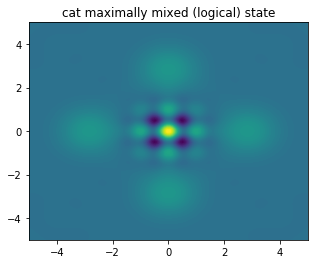

In [8]:
xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(1, 1, figsize=(5,4))
cat_mixed = (1/2*(cat_L(20, 2, 0)*cat_L(20, 2, 0).dag() + cat_L(20, 2, 1)*cat_L(20, 2, 1).dag()))
W_cat_mixed = wigner(cat_mixed, xvec, xvec)
cont = axes.contourf(xvec, xvec, W_cat_mixed, 100)
lbl = axes.set_title("cat maximally mixed (logical) state")
plt.show()

We indeed obtain a plot comparable to the one of the original paper. We can thus confidently continue our study of this code.

***

## Pure-loss channel

We apply the pure-loss channel with `gama` varying in [0.01, 0.05, 0.10, 0.20, 0.31]. This ensemble have been chosen because it is the loss rates used to study the channel infidelity for the various codes in Table I. Indeed those loss rates give a good sample of pure-loss channels with a reasonable amount of loss.

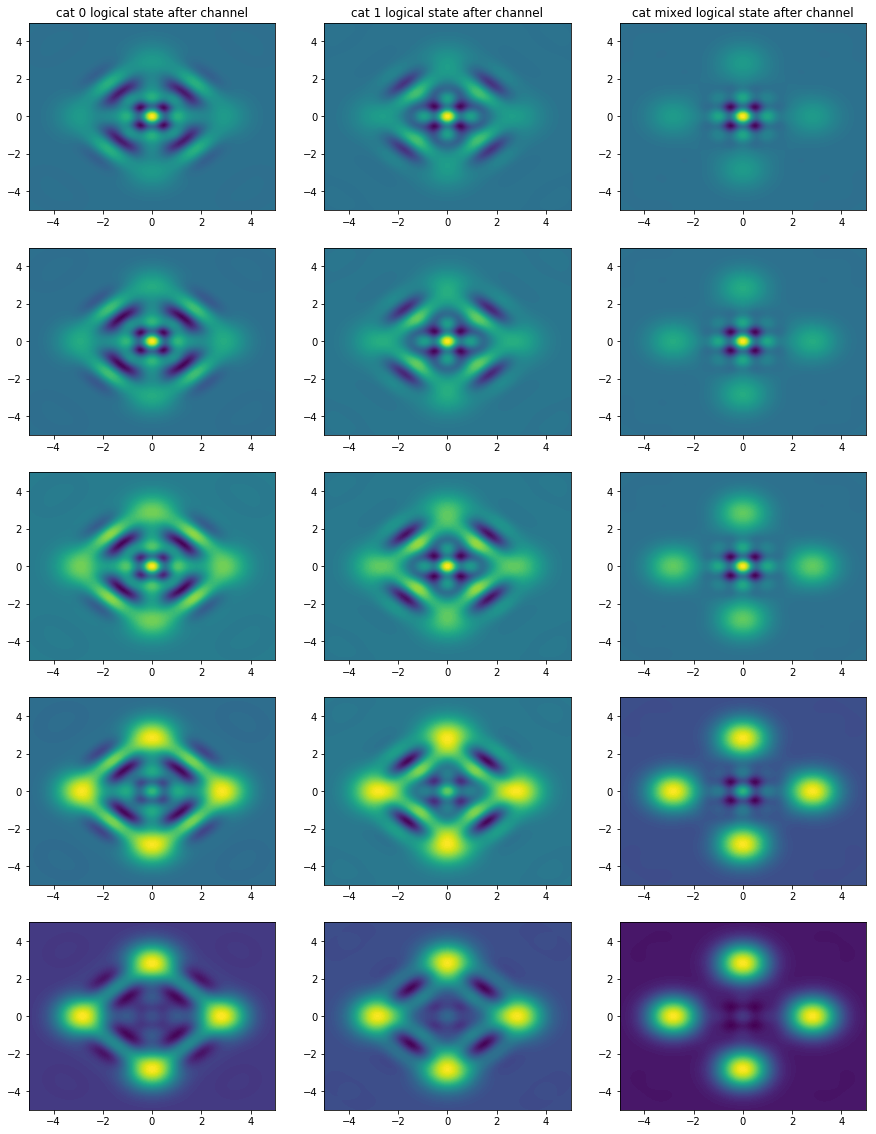

In [9]:
xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(5, 3, figsize=(15,20))
n = 0
lbl0 = axes[n][0].set_title("cat 0 logical state after channel")
lbl1 = axes[n][1].set_title("cat 1 logical state after channel")
lbl2 = axes[n][2].set_title("cat mixed logical state after channel")
for gama in (0.01,0.05,0.1,0.2,0.31):
    W_cat_0_C = wigner(chan(density(cat_L(20, 2, 0)), 20, gama), xvec, xvec)
    W_cat_1_C = wigner(chan(density(cat_L(20, 2, 1)), 20, gama), xvec, xvec)
    W_cat_m_C = wigner(chan(density(cat_mixed), 20, gama), xvec, xvec)
    cont0 = axes[n][0].contourf(xvec, xvec, W_cat_0_C, 100)
    cont1 = axes[n][1].contourf(xvec, xvec, W_cat_1_C, 100)
    cont2 = axes[n][2].contourf(xvec, xvec, W_cat_m_C, 100)
    n = n+1
plt.show()

Up to `gama = 0.1` we see a concentration on certain points, and the patterns become less clear. This is coherent with the contraction of the phase space. However, for `gama = 0.2` and `gama = 0.31` the plots regain their clarity but we see an inversion of color. I don't exactly know what to make of this.

Despite this, we still see a clear difference between the `|0>` and `|1>` logical states even at rather high loss rates, which corroborates the good ability of `cat` codes to protect against such errors.

## Overlap between codewords

Let us also plot the evolution of the overlap between the `|0>` and `|1>` codewords, as the `gama` parameter increases. We use the trace distance provided by the `tracedist` QuTiP function, and the Hilbert-Schmidt inner product given by `hilbert_dist`.
We also extend the range of `gama` to (0:0.5) in order to see also what happens after the 0.31 limit previously arbitrarly put.

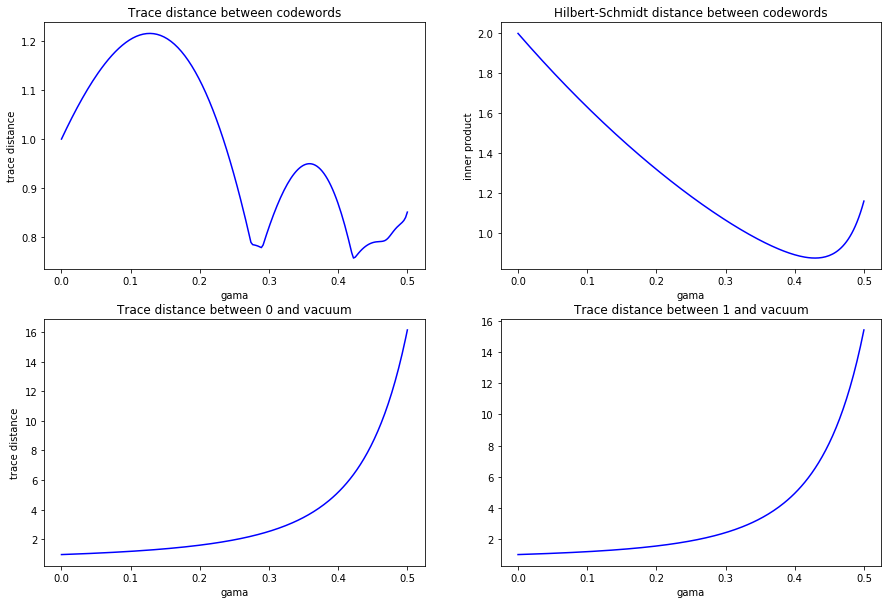

In [10]:
d_0 = density(cat_L(20, 2, 0))
d_1 = density(cat_L(20, 2, 1))
vac = fock_dm(20, 0)

xvec = np.linspace(0,0.5,200) # gama
yvec1 = [(tracedist(chan(d_0, 20, gama), chan(d_1, 20, gama))) for gama in xvec] # trace distance between codewords
yvec2 = [(tracedist(chan(d_0, 20, gama), vac)) for gama in xvec] # trace dist between 0 and vacuum
yvec3 = [(tracedist(chan(d_1, 20, gama), vac)) for gama in xvec] # trace dist between 1 and vacuum
yvec4 = [(hilbert_dist(chan(d_0, 20, gama), chan(d_1, 20, gama))) for gama in xvec] # Inner product between codewords

fig, ax = plt.subplots(2, 2, figsize=(15,10))
p0 = ax[0][0].plot(xvec, yvec1, 'b')
p1 = ax[0][1].plot(xvec, yvec4, 'b')
p1 = ax[1][0].plot(xvec, yvec2, 'b')
p1 = ax[1][1].plot(xvec, yvec3, 'b')
ax[0][0].set_xlabel('gama')
ax[1][0].set_xlabel('gama')
ax[0][1].set_xlabel('gama')
ax[1][1].set_xlabel('gama')
ax[0][0].set_ylabel('trace distance')
ax[0][1].set_ylabel('inner product')
ax[1][0].set_ylabel('trace distance')
ax[0][0].set_title('Trace distance between codewords')
ax[0][1].set_title('Hilbert-Schmidt distance between codewords')
ax[1][0].set_title('Trace distance between 0 and vacuum')
ax[1][1].set_title('Trace distance between 1 and vacuum')
plt.show()

# TODO

****

# The binomial code
## Definition

The `bin` codes are defined by two parameters, `N` and `S`. This `N` is not to be mistaken with the `N` previously defined as the number of levels in the Hilbert space; here, it defines to which order in `gama` the code can correct exactly dephasing errors. It can be seen as similar to the `alpha` parameter in the `cat` codes. The second parameter, `S` is the same spacing parameter as for the `cat` code, defining the spacing of the Fock states supporting the logical states. This similarity between the `bin` and `cat` is best seen in the fact that, for a fixed `S`, they are equivalent for `alpha` and `N` close to infinity.

Thus, it comes as no surprise that `bin` codes can detect and sometimes correct errors due to loss events in the same way that `cat` codes do.

The main difference between `bin` and `code` codes come at larger `S`: since there exists those so-called "sweet spots" for the `cat` codes, there is an intermediate `n` regime, between those sweet spots, in which the `cat` codes underperforms while the `bin` continue to improve. However, since for the visual representations we stay at low levels of `S`, the two codes should not seem to perform differently.

***

Here we have chosen the `bin(N = 1, S = 2)` for the sole reason that it is the one represented in the original paper in Figure 1, and we can thus compare our representation of the maximally mixed state of this code with the original one. We use the equation (6.1) to express the logical states:

In [11]:
def bin_L(N, mu):
    l = Qobj()
    l = fock(N,0) + ((-1)**mu)*np.sqrt(2)*fock(N,3) + fock(N,6)
    l = 1/2*l
    return l.unit()

## Representation of the logical states

We use the same code -- same plotting function, same size, same dimension -- as for the `cat` code. We represent the `|0>`, `|1>` and maximally mixed state side by side.

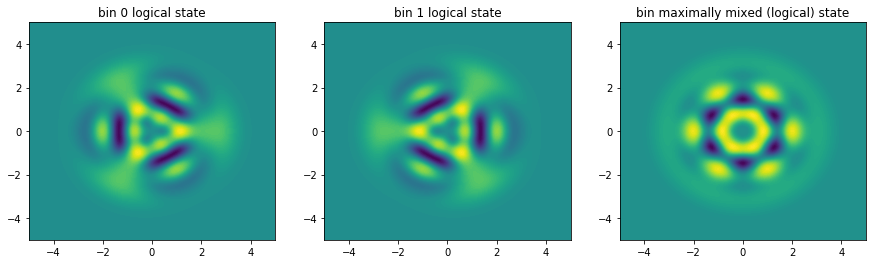

In [12]:
xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(1, 3, figsize=(15,4))
W_bin_0 = wigner(bin_L(20, 0), xvec, xvec)
W_bin_1 = wigner(bin_L(20, 1), xvec, xvec)
bin_mixed = (1/2*(bin_L(20, 0)*bin_L(20, 0).dag() + bin_L(20, 1)*bin_L(20, 1).dag()))
W_bin_mixed = wigner(bin_mixed, xvec, xvec)
cont0 = axes[0].contourf(xvec, xvec, W_bin_0, 100)
lbl0 = axes[0].set_title("bin 0 logical state")
cont1 = axes[1].contourf(xvec, xvec, W_bin_1, 100)
lbl1 = axes[1].set_title("bin 1 logical state")
cont2 = axes[2].contourf(xvec, xvec, W_bin_mixed, 100)
lbl2 = axes[2].set_title("bin maximally mixed (logical) state")
plt.show()

The plot for the maximally mixed state is very similar to the one on Figure 1 in the original paper. We thus again continue confidently our analysis.

***

## Pure-loss channel

We then apply the pure-loss channel defined earlier on those three quantum states, using the same ensemble for the `gama` variable:

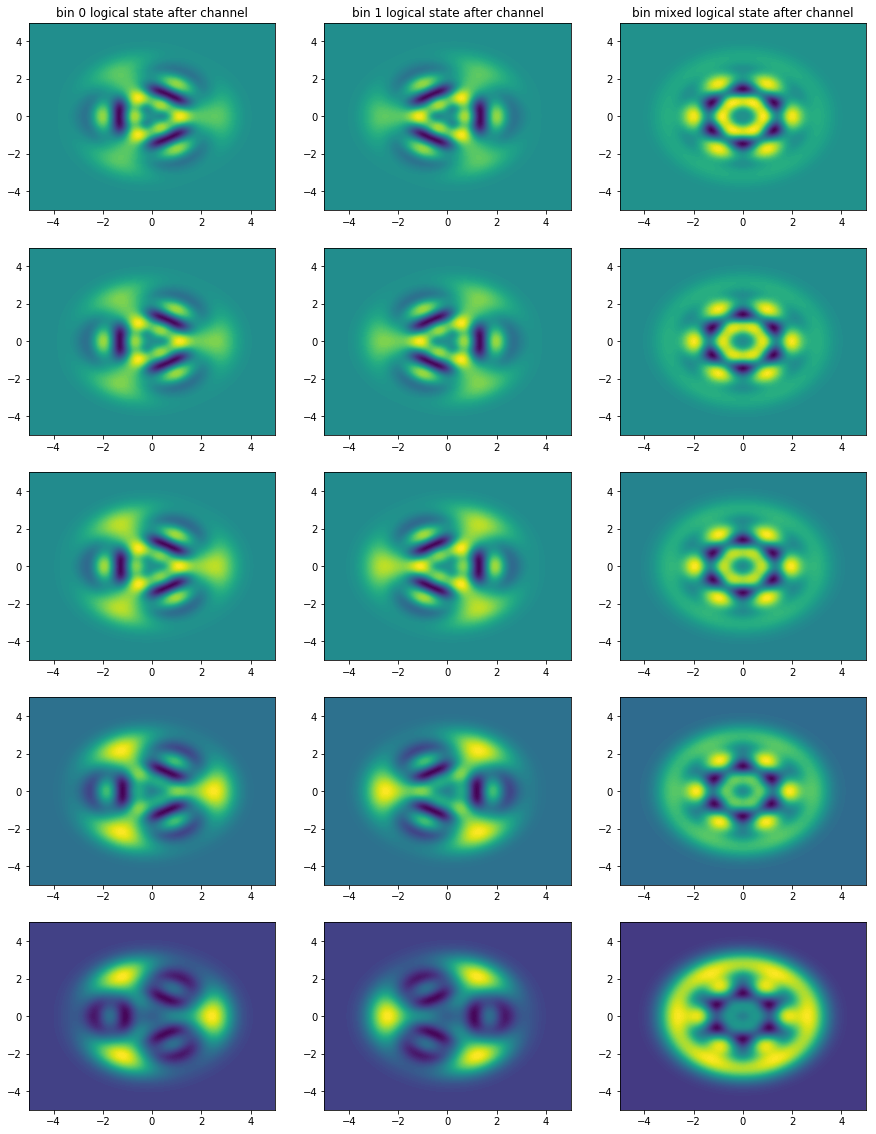

In [13]:
xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(5, 3, figsize=(15,20))
n = 0
lbl0 = axes[n][0].set_title("bin 0 logical state after channel")
lbl1 = axes[n][1].set_title("bin 1 logical state after channel")
lbl2 = axes[n][2].set_title("bin mixed logical state after channel")
for gama in (0.01,0.05,0.1,0.2,0.31):
    W_bin_0_C = wigner(chan(density(bin_L(20, 0)), 20, gama), xvec, xvec)
    W_bin_1_C = wigner(chan(density(bin_L(20, 1)), 20, gama), xvec, xvec)
    W_bin_m_C = wigner(chan(density(bin_mixed), 20, gama), xvec, xvec)
    cont0 = axes[n][0].contourf(xvec, xvec, W_bin_0_C, 100)
    cont1 = axes[n][1].contourf(xvec, xvec, W_bin_1_C, 100)
    cont1 = axes[n][2].contourf(xvec, xvec, W_bin_m_C, 100)
    n = n+1
plt.show()

Here again we lose clarity as the loss rate increases, this time without the difference between lower and higher values; there is no switching of values, only the progressive blurring of the plot. Still, the distinction between the density matrices of the two basis states is clearly visible. This goes along the results of the original paper. 

However, using only the visual representation, there seems to be no way of comparing the efficiency of the different codes. Though the `bin` and `cat` codes, such chosen, are shown by a numerical analysis to perform similarly, this cannot be seen by comparing only the density matrices. In order to make such a comparison, we could use the channel fidelity as defined in the original paper by equation (1.10) -- the overlap between the initial state and the final state. Nevertheless, this channel fidelity is a dimensionless number which cannot be "seen" using the Wigner plot visual representation.

The only thing that can be seen when comparing those two codes is that, considering the maximally mixed states, the blurring of the Wigner function seems to increase at the about the same rate.

## Overlap between codewords

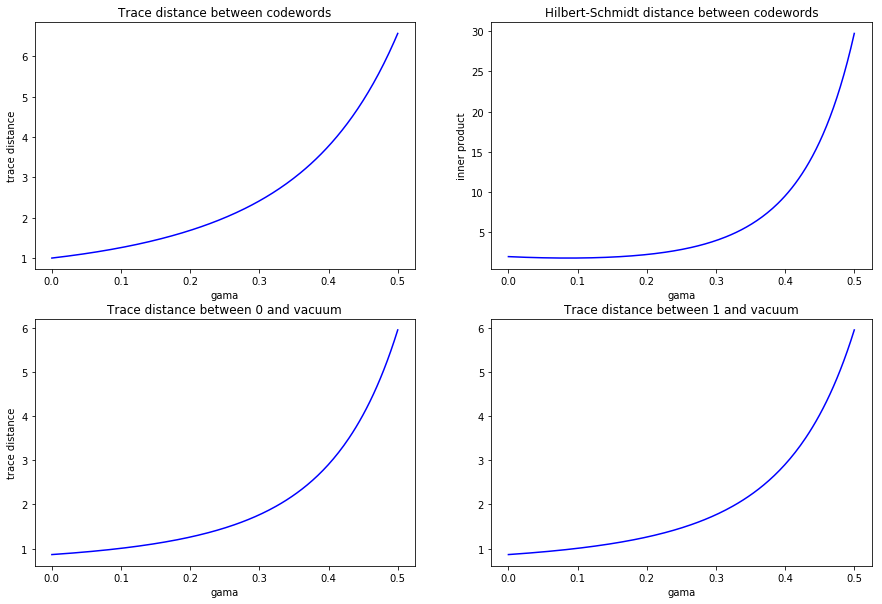

In [14]:
d_0 = density(bin_L(20, 0))
d_1 = density(bin_L(20, 1))
vac = fock_dm(20)

xvec = np.linspace(0,0.5,200) # gama
yvec1 = [(tracedist(chan(d_0, 20, gama), chan(d_1, 20, gama))) for gama in xvec] # trace distance between codewords
yvec2 = [(tracedist(chan(d_0, 20, gama), vac)) for gama in xvec] # trace dist between 0 and vacuum
yvec3 = [(tracedist(chan(d_1, 20, gama), vac)) for gama in xvec] # trace dist between 1 and vacuum
yvec4 = [(hilbert_dist(chan(d_0, 20, gama), chan(d_1, 20, gama))) for gama in xvec] # Inner product between codewords

fig, ax = plt.subplots(2, 2, figsize=(15,10))
p0 = ax[0][0].plot(xvec, yvec1, 'b')
p1 = ax[0][1].plot(xvec, yvec4, 'b')
p1 = ax[1][0].plot(xvec, yvec2, 'b')
p1 = ax[1][1].plot(xvec, yvec3, 'b')
ax[0][0].set_xlabel('gama')
ax[1][0].set_xlabel('gama')
ax[0][1].set_xlabel('gama')
ax[1][1].set_xlabel('gama')
ax[0][0].set_ylabel('trace distance')
ax[0][1].set_ylabel('inner product')
ax[1][0].set_ylabel('trace distance')
ax[0][0].set_title('Trace distance between codewords')
ax[0][1].set_title('Hilbert-Schmidt distance between codewords')
ax[1][0].set_title('Trace distance between 0 and vacuum')
ax[1][1].set_title('Trace distance between 1 and vacuum')
plt.show()

We observe about the same general shape as for the `cat` codes, with the main difference being the value of the trace distance: while it was small before, around `10^-3`, it now goes from 1 to 1.30, which is a smaller increase that before (30% against 40%). This could be linked to the findings of the original paper (Figure 2.(a)) that although the `bin` codes perform better than the `cat` codes for `gama < 0.2` (the distance between codewords being more important), this shifts for `gama > 0.2`, just as the distance between codewords increases proportionally more for `cat` codes.


***

# The numerical code
## Definition

The `num`erically optimized codes were designed, like the `bin` codes, to protect exactly against errors consisting of powers of raising and lowering operators, up to some maximum order here defined by the `n` parameter. 

I could not find a formal definition of this class of codes, nor in the original paper nor in the one cited as source for some of those codes. Because of this, we use the expression of the logical states of a `num` given in appendix B for `n = 1.562` -- the only one to be found. We observe that, similarly to the previous `bin` codes, the basis logical states are supported by Fock states. Nevertheless, the spacing here is not constant, the `|0>` state being supported by the `|0>` and `|3>` Fock states, and the `|1>` by the `|1>` and `|4>` Fock states.

In [15]:
def num_L(N, mu):
    l = Qobj()
    if (mu == 0):
        l = 1/np.sqrt(6)*(np.sqrt(7-np.sqrt(17))*fock(N,0)+np.sqrt(np.sqrt(17)-1)*fock(N,3))
    if (mu == 1):
        l = 1/np.sqrt(6)*(np.sqrt(9-np.sqrt(17))*fock(N,1)+np.sqrt(np.sqrt(17)-3)*fock(N,4))
    return l

## Representation of the logical states

We keep the same canvas as before to plot the three chosen logical states:

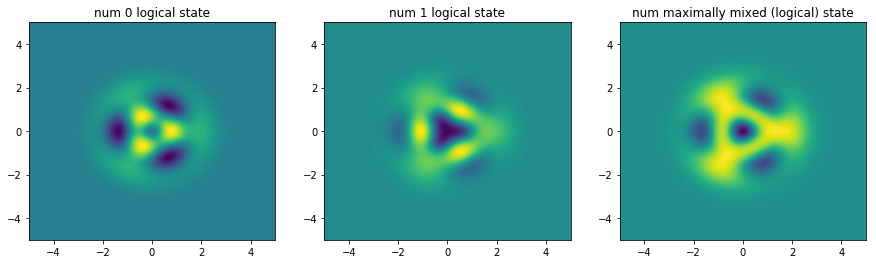

In [16]:
xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(1, 3, figsize=(15,4))
W_num_0 = wigner(num_L(20, 0), xvec, xvec)
W_num_1 = wigner(num_L(20, 1), xvec, xvec)
num_mixed = (1/2*(num_L(20, 0)*num_L(20, 0).dag() + num_L(20, 1)*num_L(20, 1).dag()))
W_num_mixed = wigner(num_mixed, xvec, xvec)
cont0 = axes[0].contourf(xvec, xvec, W_num_0, 100)
lbl0 = axes[0].set_title("num 0 logical state")
cont1 = axes[1].contourf(xvec, xvec, W_num_1, 100)
lbl1 = axes[1].set_title("num 1 logical state")
cont2 = axes[2].contourf(xvec, xvec, W_num_mixed, 100)
lbl2 = axes[2].set_title("num maximally mixed (logical) state")
plt.show()

Unfortunatly, we cannot compare this mixed state to the one ploted in Figure 1 in the original paper, since we only have the formula for the logical states for `num(n = 1.562)` and they plotted `num(n = 2.696)`. Still, we observe similar symetries, and the same round pattern.

***

## Pure-loss channel

Here again we plot the state after applying the channel's first two Kraus operators:

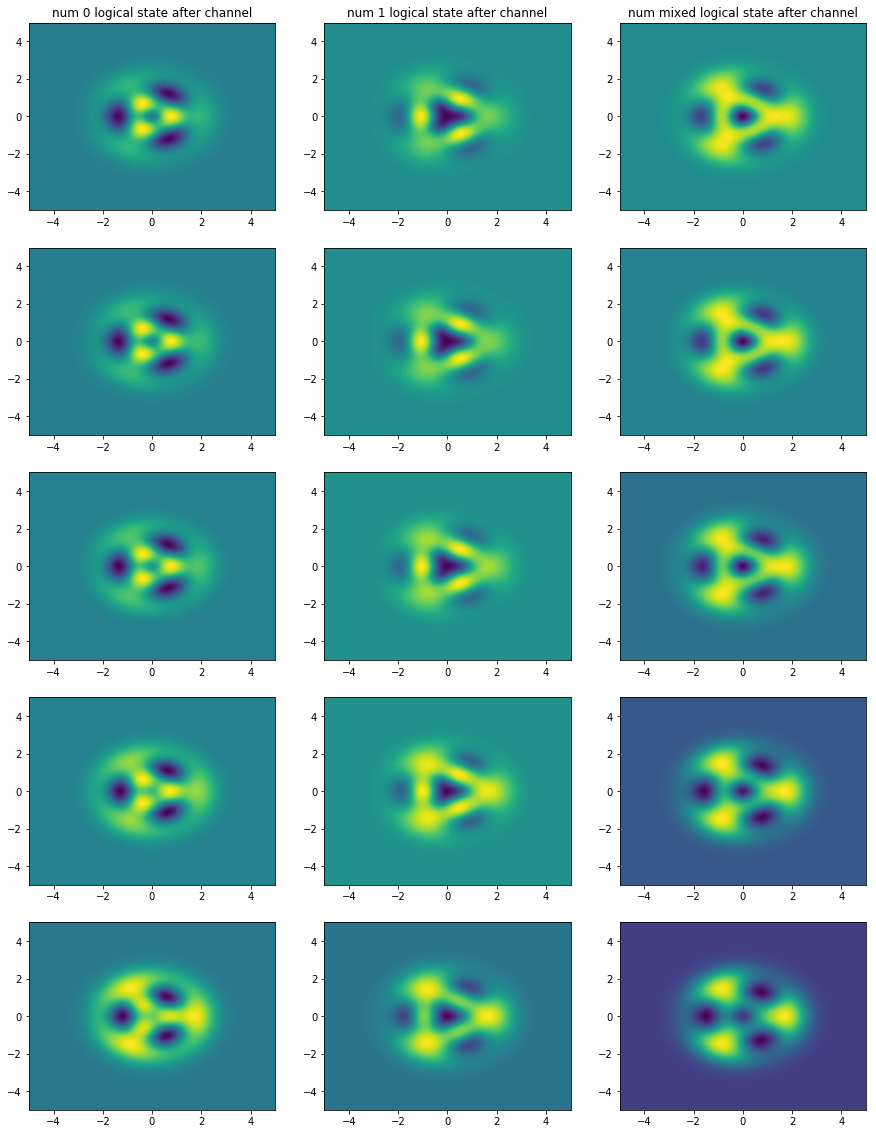

In [17]:
xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(5, 3, figsize=(15,20))
n = 0
lbl0 = axes[n][0].set_title("num 0 logical state after channel")
lbl1 = axes[n][1].set_title("num 1 logical state after channel")
lbl2 = axes[n][2].set_title("num mixed logical state after channel")
for gama in (0.01,0.05,0.1,0.2,0.31):
    W_num_0_C = wigner(chan(density(num_L(20, 0)), 20, gama), xvec, xvec)
    W_num_1_C = wigner(chan(density(num_L(20, 1)), 20, gama), xvec, xvec)
    W_num_m_C = wigner(chan(density(num_mixed), 20, gama), xvec, xvec)
    cont0 = axes[n][0].contourf(xvec, xvec, W_num_0_C, 100)
    cont1 = axes[n][1].contourf(xvec, xvec, W_num_1_C, 100)
    cont1 = axes[n][2].contourf(xvec, xvec, W_num_m_C, 100)
    n = n+1
plt.show()

## Overlap of the codewords

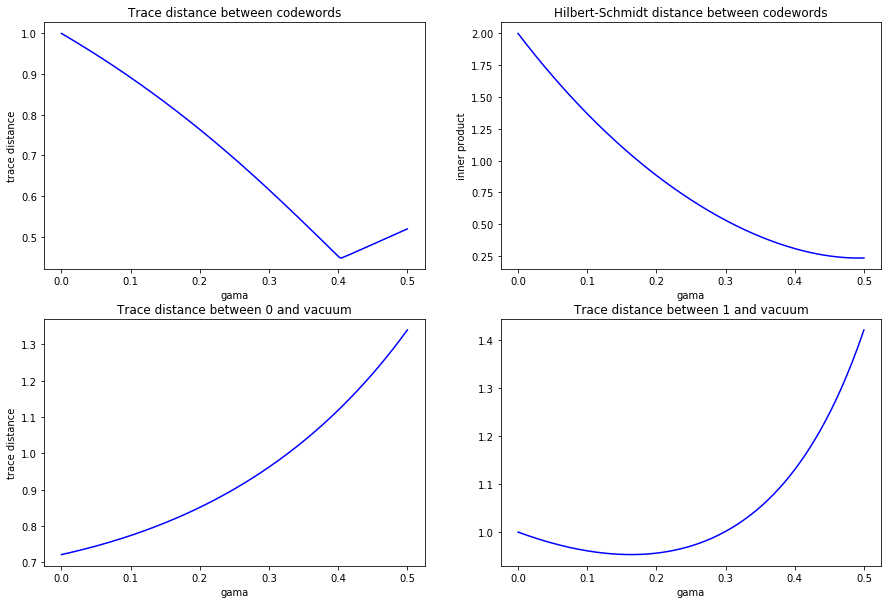

In [18]:
d_0 = density(num_L(20, 0))
d_1 = density(num_L(20, 1))
vac = fock_dm(20)

xvec = np.linspace(0,0.5,200) # gama
yvec1 = [(tracedist(chan(d_0, 20, gama), chan(d_1, 20, gama))) for gama in xvec] # trace distance between codewords
yvec2 = [(tracedist(chan(d_0, 20, gama), vac)) for gama in xvec] # trace dist between 0 and vacuum
yvec3 = [(tracedist(chan(d_1, 20, gama), vac)) for gama in xvec] # trace dist between 1 and vacuum
yvec4 = [(hilbert_dist(chan(d_0, 20, gama), chan(d_1, 20, gama))) for gama in xvec] # Inner product between codewords

fig, ax = plt.subplots(2, 2, figsize=(15,10))
p0 = ax[0][0].plot(xvec, yvec1, 'b')
p1 = ax[0][1].plot(xvec, yvec4, 'b')
p1 = ax[1][0].plot(xvec, yvec2, 'b')
p1 = ax[1][1].plot(xvec, yvec3, 'b')
ax[0][0].set_xlabel('gama')
ax[1][0].set_xlabel('gama')
ax[0][1].set_xlabel('gama')
ax[1][1].set_xlabel('gama')
ax[0][0].set_ylabel('trace distance')
ax[0][1].set_ylabel('inner product')
ax[1][0].set_ylabel('trace distance')
ax[0][0].set_title('Trace distance between codewords')
ax[0][1].set_title('Hilbert-Schmidt distance between codewords')
ax[1][0].set_title('Trace distance between 0 and vacuum')
ax[1][1].set_title('Trace distance between 1 and vacuum')
plt.show()

# TODO

***

# The GKPs codes
## Definition

The `gkps` codes are the first `gkp` code type designed, with the s standing for "square", because those first codes were based on square lattices. It is only latter on that more general `gkp` codes were introduced with shifted lattices. The `gkps` codes are presented seperatly to account for possible particularities according to the form of the lattice.

***

Those codes are constructed by adding a `delta`^2 dependent Gaussian envelope to the ideal square lattice `gkps` codespace, which, having infinite mean occupation number, is not normalizable. This one in turn is defined by its projection, which is the simultaneous +1 eigenspace of two commuting displacement operators. 

For practical reasons -- namely that the QuTiP library enable us to easily calculate those displacement operators -- we use the version without normalization given by equation (7.7b). However, since python does not support infinite summation of anything other than integers, we approximate the sum by its -100 to 100 terms. 

In [19]:
def gkps_L(N, mu, delta):
    l = Qobj()
    l = sum((sum(
        (np.exp(-(np.pi/2)*(delta**2)*((2*n+mu)**2 + k**2))
         *displace(N, (np.sqrt(np.pi/2)*(2*n+mu)))
         *displace(N, (1J*np.sqrt(np.pi/2)*k))
         *fock(N, 0)) 
        for k in range(-50,50))) for n in range(-100,100))
    return l

## Representation of the logical states

We here take the parameter `delta` to be 0.5, in order to be able to once again compare the Wigner function of the maximmaly mixed state we obtain to the one shown in Figure 1.

***Remark:*** Here, we calculate only once the logical states in order to minimize the calls to the `gkps_L` function which takes some time to compute due to the size of the double sum.

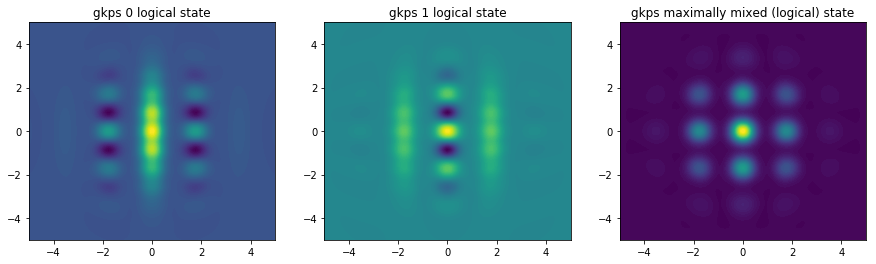

In [20]:
xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(1, 3, figsize=(15,4))
gkps_0 = gkps_L(20, 0, 0.5)
gkps_1 = gkps_L(20, 1, 0.5)
W_gkps_0 = wigner(gkps_0, xvec, xvec)
W_gkps_1 = wigner(gkps_1, xvec, xvec)
gkps_mixed = (1/2*(gkps_0*gkps_0.dag() + gkps_1*gkps_1.dag()))
W_gkps_mixed = wigner(gkps_mixed, xvec, xvec)
cont0 = axes[0].contourf(xvec, xvec, W_gkps_0, 100)
lbl0 = axes[0].set_title("gkps 0 logical state")
cont1 = axes[1].contourf(xvec, xvec, W_gkps_1, 100)
lbl1 = axes[1].set_title("gkps 1 logical state")
cont2 = axes[2].contourf(xvec, xvec, W_gkps_mixed, 100)
lbl2 = axes[2].set_title("gkps maximally mixed (logical) state")
plt.show()

We indeed obtain the same plot, which confirms that we have well implemented the model described by this paper. 

They also mention that for non zero `delta`, the `|0>` and `|1>` logical states are non-orthogonal, which spans error inherent to the code structure. However, This propriety does not seem obvious when seeing those two states side by side.

***

## Pure-loss channel

We once more use the same canvas to model the pure-loss channel action:

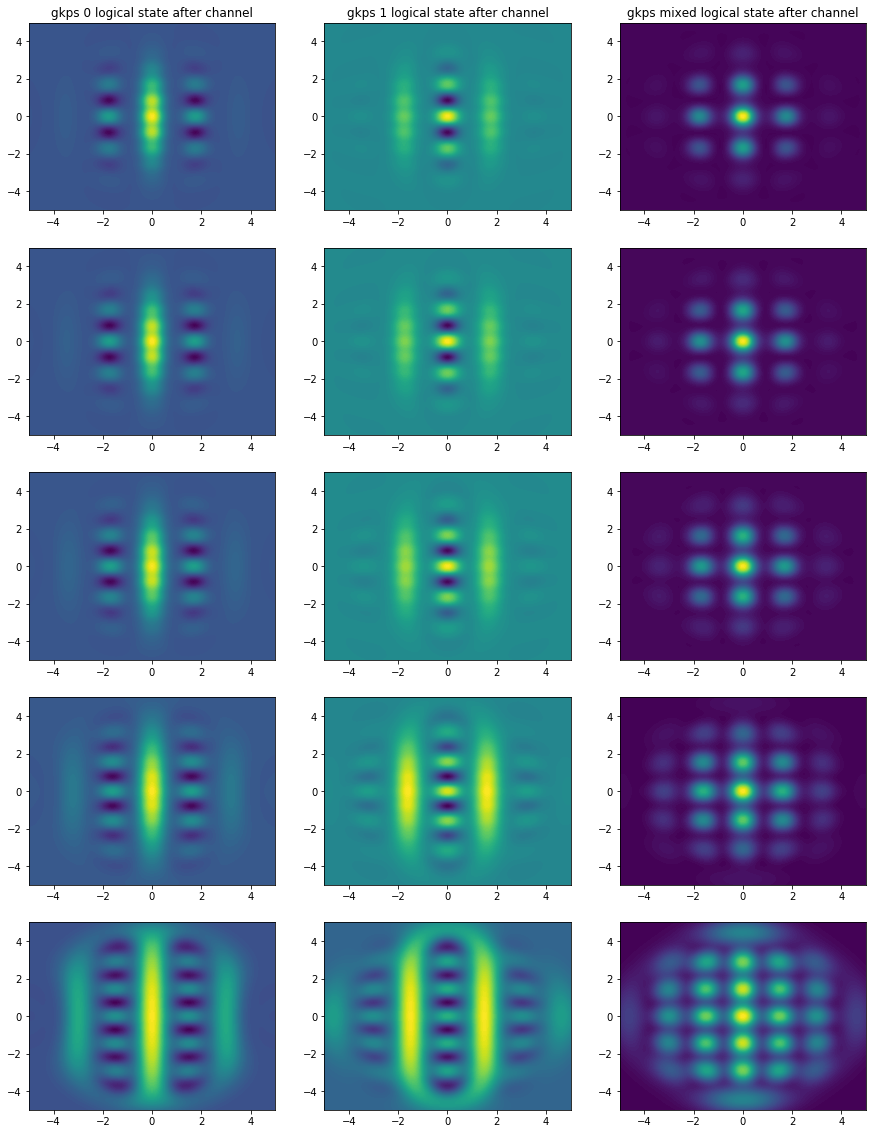

In [21]:
xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(5, 3, figsize=(15,20))
n = 0
lbl0 = axes[n][0].set_title("gkps 0 logical state after channel")
lbl1 = axes[n][1].set_title("gkps 1 logical state after channel")
lbl2 = axes[n][2].set_title("gkps mixed logical state after channel")
for gama in (0.01,0.05,0.1,0.2,0.31):
    W_gkps_0_C = wigner(chan(density(gkps_0), 20, gama), xvec, xvec)
    W_gkps_1_C = wigner(chan(density(gkps_1), 20, gama), xvec, xvec)
    W_gkps_m_C = wigner(chan(density(gkps_mixed), 20, gama), xvec, xvec)
    cont0 = axes[n][0].contourf(xvec, xvec, W_gkps_0_C, 100)
    cont1 = axes[n][1].contourf(xvec, xvec, W_gkps_1_C, 100)
    cont1 = axes[n][2].contourf(xvec, xvec, W_gkps_m_C, 100)
    n = n+1
plt.show()

Here we see a very different phenomenon than for the other codes. The code subspace does not suffer from a contraction, seen as a blurring of the plot for rather small `gama` parameters, but from a more complexe distortion in which new patterns appear. This can be linked to the results on code performance of the original paper. Indeed, they found out that though `gkp` -- and more particularly `gkps` codes does not perform significantly better at low `gama`, they greatly outperform every other code type when `gama > 0.1`, especially at higher mean occupation number. This limit is when the first distortions of the density matrix appear on the Wigner function plot.

Thus it seems that the `gkps` codes outperform the others at higher `gama` because the distortion induced by the pure-loss channel increases the distinguishability of the two basis logical states, an effect that counterbalances the inherent errors of the `gkps`codes -- namely, that the two basis states are non-orthogonal -- and the errors induced by the channel.

## Overlap of the codewords

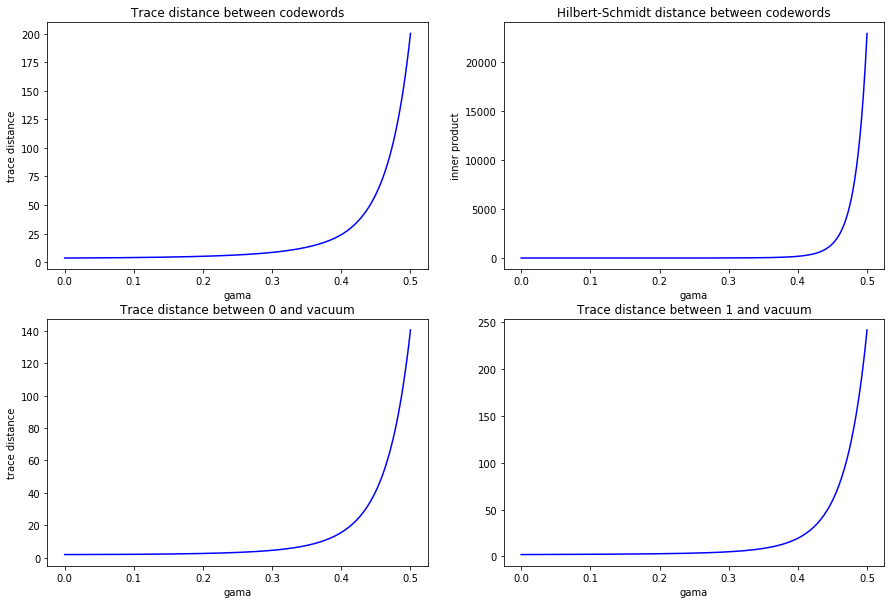

In [22]:
d_0 = density(gkps_0)
d_1 = density(gkps_1)
vac = fock_dm(20)

xvec = np.linspace(0,0.5,200) # gama
yvec1 = [(tracedist(chan(d_0, 20, gama), chan(d_1, 20, gama))) for gama in xvec] # trace distance between codewords
yvec2 = [(tracedist(chan(d_0, 20, gama), vac)) for gama in xvec] # trace dist between 0 and vacuum
yvec3 = [(tracedist(chan(d_1, 20, gama), vac)) for gama in xvec] # trace dist between 1 and vacuum
yvec4 = [(hilbert_dist(chan(d_0, 20, gama), chan(d_1, 20, gama))) for gama in xvec] # Inner product between codewords

fig, ax = plt.subplots(2, 2, figsize=(15,10))
p0 = ax[0][0].plot(xvec, yvec1, 'b')
p1 = ax[0][1].plot(xvec, yvec4, 'b')
p1 = ax[1][0].plot(xvec, yvec2, 'b')
p1 = ax[1][1].plot(xvec, yvec3, 'b')
ax[0][0].set_xlabel('gama')
ax[1][0].set_xlabel('gama')
ax[0][1].set_xlabel('gama')
ax[1][1].set_xlabel('gama')
ax[0][0].set_ylabel('trace distance')
ax[0][1].set_ylabel('inner product')
ax[1][0].set_ylabel('trace distance')
ax[0][0].set_title('Trace distance between codewords')
ax[0][1].set_title('Hilbert-Schmidt distance between codewords')
ax[1][0].set_title('Trace distance between 0 and vacuum')
ax[1][1].set_title('Trace distance between 1 and vacuum')
plt.show()

# TODO

***

# Conclusion

We have succesfully plotted the logical states of different codes before and after going through a pure-loss channel. Although it is not possible using this visual representation to compare precisely the performance of these codes, it gives a rough estimate of the differences, mostly between the `gkp` codes and the others. 

Most importantly, it gives a nice visual representation of the effects of an increasing loss rate of the channel: the differences are clearly visible between the post-channel states for very low (0.01) and for higher (0.31) loss rates. Furthermore, those differences seem to increase continously.

***